In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# lib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# training
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# metric
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score

# model
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
import catboost
from catboost import CatBoostClassifier

# model save & load
import joblib 
from tensorflow.keras.models import load_model


import warnings
warnings.filterwarnings('ignore')

/kaggle/input/traintest/fp_test_dataset.csv
/kaggle/input/traintest/fp_train_dataset.csv


In [2]:
# reduce memory
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [3]:
og_test = pd.read_csv('../input/traintest/fp_test_dataset.csv')
og_train = pd.read_csv('../input/traintest/fp_train_dataset.csv')

In [4]:
og_test = reduce_mem_usage(og_test)
og_train = reduce_mem_usage(og_train)

Memory usage after optimization is: 17.55 MB
Decreased by 61.0%
Memory usage after optimization is: 70.21 MB
Decreased by 61.0%


원본 데이터셋을 합쳐서 특정 컬럼을 드랍하고 레이블 인코딩을 하는 등 전처리 과정이 필요했습니다.  
때문에 전처리 전의 데이터셋은 'og_'라는 단어를 앞에 붙여서 표기했습니다.

In [5]:
print(og_train.shape)
og_train

(575192, 41)


,Unnamed: 0,label,user_id,imp_id,content_id,server_time_kst,content_bid_price,device_type,c_user_gender,c_user_age,...,advertiser_review_count,advertiser_comment_count,advertiser_follow_count,advertiser_pay_count,advertiser_parcel_post_count,advertiser_transfer_count,advertiser_chat_count,hour,view_count,content_count
0,482947,0,9729642,971a612de75e0ed31601,158260898,2021-08-31 17:25:10.558000+09:00,50,a,1,15,...,1930,408,0,83,8,0,14,17,33,2.900391
1,712653,0,3785173,97cf612e195e0aed0b83,162787921,2021-08-31 20:58:31.746000+09:00,50,a,2,53,...,25,43,0,18,0,0,1,20,2,-0.199951
2,20716,0,12333079,99d1612d51fa209e74c5,162853021,2021-08-31 06:47:45.935000+09:00,50,a,2,45,...,254,215,0,63,560,0,0,6,56,5.199219
3,170643,0,9079063,9919612d9bae214a1198,137118119,2021-08-31 12:02:45.602000+09:00,50,a,2,83,...,542,739,0,496,0,0,11,12,3,-0.099976
4,226005,0,74280651,9919612d3cc7207b5164,137118198,2021-08-31 05:17:15.645000+09:00,60,a,2,64,...,542,739,0,496,0,0,11,5,6,0.199951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
575187,291988,0,76710168,97ca612d1f2711182e4b,163132249,2021-08-31 03:10:52.516000+09:00,50,a,1,23,...,0,6,0,0,0,0,0,3,4,0.000000
575188,240466,0,74302776,998c612e43160280f81f,152630055,2021-08-31 23:56:27.317000+09:00,50,a,1,58,...,9,0,0,18,0,0,1,23,35,3.099609
575189,145580,0,77288966,97f9612d28161488f57e,97209583,2021-08-31 03:49:29.201000+09:00,55,a,1,18,...,223,431,0,232,9,1,4,3,4,0.000000
575190,401189,0,76612273,998c612dec8200d4b578,152825533,2021-08-31 17:47:07.388000+09:00,50,a,1,36,...,127,23,0,81,0,0,2,17,1,-0.300049


In [6]:
print(og_test.shape)
og_test

(143799, 41)


,Unnamed: 0,label,user_id,imp_id,content_id,server_time_kst,content_bid_price,device_type,c_user_gender,c_user_age,...,advertiser_review_count,advertiser_comment_count,advertiser_follow_count,advertiser_pay_count,advertiser_parcel_post_count,advertiser_transfer_count,advertiser_chat_count,hour,view_count,content_count
0,606912,0,10620482,97cf612d95dc08f2f098,54106626,2021-08-31 11:38:26.663000+09:00,50,a,1,41,...,2172,1908,0,438,0,19,21,11,1,-0.300049
1,681182,0,76738316,99d1612d970d21479ba3,161528170,2021-08-31 11:42:52.948000+09:00,50,a,1,43,...,883,1049,0,1088,231,298,41,11,1,-0.300049
2,370565,0,76862637,9919612d863a2103f61d,130331547,2021-08-31 10:30:39.133000+09:00,245,a,1,17,...,141,131,0,0,0,0,3,10,5,0.099976
3,630619,0,11253153,9919612dfbff22abe4d9,128774768,2021-08-31 18:53:13.523000+09:00,50,a,2,18,...,116,478,0,173,0,0,9,18,3,-0.099976
4,19265,0,4242274,97f9612e3fab182ebfba,100010275,2021-08-31 23:41:53.543000+09:00,60,a,1,48,...,775,529,0,575,0,35,130,23,9,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143794,493912,0,7758479,971a612db0b10e073bd8,86915563,2021-08-31 13:31:58.081000+09:00,50,a,1,44,...,2172,1908,0,438,0,19,21,13,7,0.300049
143795,184995,0,13020787,97cf612d978708f8a436,161585727,2021-08-31 11:44:43.885000+09:00,65,a,1,63,...,229,391,0,75,653,18,41,11,1,-0.300049
143796,291776,0,74591039,971a612e22aa0fd75ed3,163132249,2021-08-31 21:38:07.663000+09:00,60,a,1,45,...,0,6,0,0,0,0,0,21,8,0.399902
143797,693735,0,4523798,971a612e16900f983634,152625380,2021-08-31 20:49:10.195000+09:00,50,a,2,43,...,127,23,0,81,0,0,2,20,1,-0.300049


In [7]:
og_train.columns

Index(['Unnamed: 0', 'label', 'user_id', 'imp_id', 'content_id',
       'server_time_kst', 'content_bid_price', 'device_type', 'c_user_gender',
       'c_user_age', 'user_following_count', 'user_pay_count',
       'user_parcel_post_count', 'user_transfer_count', 'user_chat_count',
       'advertiser_id', 'content_name', 'content_keyword', 'content_price',
       'content_flag_used', 'c_content_category_id_1',
       'c_content_category_id_2', 'c_content_category_id_3',
       'content_emergency_count', 'content_comment_count',
       'content_interest_count', 'content_favorite_count',
       'advertiser_favorite_count', 'advertiser_grade',
       'advertiser_item_count', 'advertiser_interest_count',
       'advertiser_review_count', 'advertiser_comment_count',
       'advertiser_follow_count', 'advertiser_pay_count',
       'advertiser_parcel_post_count', 'advertiser_transfer_count',
       'advertiser_chat_count', 'hour', 'view_count', 'content_count'],
      dtype='object')

In [8]:
dataset = pd.concat([og_train, og_test])
dataset.reset_index(drop = True, inplace = True)
dataset

,Unnamed: 0,label,user_id,imp_id,content_id,server_time_kst,content_bid_price,device_type,c_user_gender,c_user_age,...,advertiser_review_count,advertiser_comment_count,advertiser_follow_count,advertiser_pay_count,advertiser_parcel_post_count,advertiser_transfer_count,advertiser_chat_count,hour,view_count,content_count
0,482947,0,9729642,971a612de75e0ed31601,158260898,2021-08-31 17:25:10.558000+09:00,50,a,1,15,...,1930,408,0,83,8,0,14,17,33,2.900391
1,712653,0,3785173,97cf612e195e0aed0b83,162787921,2021-08-31 20:58:31.746000+09:00,50,a,2,53,...,25,43,0,18,0,0,1,20,2,-0.199951
2,20716,0,12333079,99d1612d51fa209e74c5,162853021,2021-08-31 06:47:45.935000+09:00,50,a,2,45,...,254,215,0,63,560,0,0,6,56,5.199219
3,170643,0,9079063,9919612d9bae214a1198,137118119,2021-08-31 12:02:45.602000+09:00,50,a,2,83,...,542,739,0,496,0,0,11,12,3,-0.099976
4,226005,0,74280651,9919612d3cc7207b5164,137118198,2021-08-31 05:17:15.645000+09:00,60,a,2,64,...,542,739,0,496,0,0,11,5,6,0.199951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
718986,493912,0,7758479,971a612db0b10e073bd8,86915563,2021-08-31 13:31:58.081000+09:00,50,a,1,44,...,2172,1908,0,438,0,19,21,13,7,0.300049
718987,184995,0,13020787,97cf612d978708f8a436,161585727,2021-08-31 11:44:43.885000+09:00,65,a,1,63,...,229,391,0,75,653,18,41,11,1,-0.300049
718988,291776,0,74591039,971a612e22aa0fd75ed3,163132249,2021-08-31 21:38:07.663000+09:00,60,a,1,45,...,0,6,0,0,0,0,0,21,8,0.399902
718989,693735,0,4523798,971a612e16900f983634,152625380,2021-08-31 20:49:10.195000+09:00,50,a,2,43,...,127,23,0,81,0,0,2,20,1,-0.300049


전처리를 위해 하나의 데이터셋으로 만들어야 했기 때문에 train/test 데이터셋을 세로 방향으로 합칩니다.  

In [9]:
dataset.drop(['Unnamed: 0', 'server_time_kst', 'device_type', 'content_name', 'content_keyword'], axis = 1, inplace = True)
dataset

,label,user_id,imp_id,content_id,content_bid_price,c_user_gender,c_user_age,user_following_count,user_pay_count,user_parcel_post_count,...,advertiser_review_count,advertiser_comment_count,advertiser_follow_count,advertiser_pay_count,advertiser_parcel_post_count,advertiser_transfer_count,advertiser_chat_count,hour,view_count,content_count
0,0,9729642,971a612de75e0ed31601,158260898,50,1,15,1,0,0,...,1930,408,0,83,8,0,14,17,33,2.900391
1,0,3785173,97cf612e195e0aed0b83,162787921,50,2,53,58,0,1,...,25,43,0,18,0,0,1,20,2,-0.199951
2,0,12333079,99d1612d51fa209e74c5,162853021,50,2,45,0,0,0,...,254,215,0,63,560,0,0,6,56,5.199219
3,0,9079063,9919612d9bae214a1198,137118119,50,2,83,0,0,0,...,542,739,0,496,0,0,11,12,3,-0.099976
4,0,74280651,9919612d3cc7207b5164,137118198,60,2,64,0,0,0,...,542,739,0,496,0,0,11,5,6,0.199951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
718986,0,7758479,971a612db0b10e073bd8,86915563,50,1,44,25,0,1,...,2172,1908,0,438,0,19,21,13,7,0.300049
718987,0,13020787,97cf612d978708f8a436,161585727,65,1,63,0,0,0,...,229,391,0,75,653,18,41,11,1,-0.300049
718988,0,74591039,971a612e22aa0fd75ed3,163132249,60,1,45,0,0,0,...,0,6,0,0,0,0,0,21,8,0.399902
718989,0,4523798,971a612e16900f983634,152625380,50,2,43,1,0,0,...,127,23,0,81,0,0,2,20,1,-0.300049


csv로 저장하는 과정에서 생긴 Unnamed: 0과 모든 값이 통일 된 값을 갖고 있는 device_type,  
학습에 불필요하다고 판단되거나 NLP task가 적용되어야 하는 content_name, content_keyword, server_time_kst 컬럼을 드랍합니다.

In [10]:
dataset.columns

Index(['label', 'user_id', 'imp_id', 'content_id', 'content_bid_price',
       'c_user_gender', 'c_user_age', 'user_following_count', 'user_pay_count',
       'user_parcel_post_count', 'user_transfer_count', 'user_chat_count',
       'advertiser_id', 'content_price', 'content_flag_used',
       'c_content_category_id_1', 'c_content_category_id_2',
       'c_content_category_id_3', 'content_emergency_count',
       'content_comment_count', 'content_interest_count',
       'content_favorite_count', 'advertiser_favorite_count',
       'advertiser_grade', 'advertiser_item_count',
       'advertiser_interest_count', 'advertiser_review_count',
       'advertiser_comment_count', 'advertiser_follow_count',
       'advertiser_pay_count', 'advertiser_parcel_post_count',
       'advertiser_transfer_count', 'advertiser_chat_count', 'hour',
       'view_count', 'content_count'],
      dtype='object')

위에 출력된 컬럼들이 모델에 들어갈 컬럼들입니다.

In [11]:
# label encoding
categorical_features = ['imp_id', 'content_id', 'c_user_gender', 'content_flag_used', 'c_content_category_id_1',
                       'c_content_category_id_2', 'c_content_category_id_3', 'hour']

for feat in categorical_features:
    lbe = LabelEncoder()
    dataset[feat] = lbe.fit_transform(dataset[feat])  

dataset.head()

,label,user_id,imp_id,content_id,content_bid_price,c_user_gender,c_user_age,user_following_count,user_pay_count,user_parcel_post_count,...,advertiser_review_count,advertiser_comment_count,advertiser_follow_count,advertiser_pay_count,advertiser_parcel_post_count,advertiser_transfer_count,advertiser_chat_count,hour,view_count,content_count
0,0,9729642,74973,526,50,1,15,1,0,0,...,1930,408,0,83,8,0,14,17,33,2.900391
1,0,3785173,269311,1020,50,2,53,58,0,1,...,25,43,0,18,0,0,1,20,2,-0.199951
2,0,12333079,618849,1066,50,2,45,0,0,0,...,254,215,0,63,560,0,0,6,56,5.199219
3,0,9079063,455676,243,50,2,83,0,0,0,...,542,739,0,496,0,0,11,12,3,-0.099976
4,0,74280651,431740,244,60,2,64,0,0,0,...,542,739,0,496,0,0,11,5,6,0.199951


categorical feature를 label encoding합니다.  
catboost같은 경우 categorical feature의 dtype을 'category'로 명시해주면 모델이 알아서 아~ categorical feature구나 하고 인식하지만  
다른 모델의 경우 numeric한 feature만 사용이 가능하기 때문에 one-hot encoding을 하거나 label encoding을 해주어야했습니다.  
하지만 one-hot encoding을 사용하기에는 우리의 categorical feature가 user_id, imp_id 등 매우 많은 class를 갖고 있는 feature이기 때문에  
one-hot encoding을 할 경우 매우매우 sparse해질 가능성이 높아 label encoding을 진행했습니다.

In [12]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 718991 entries, 0 to 718990
Data columns (total 36 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   label                         718991 non-null  int8   
 1   user_id                       718991 non-null  int32  
 2   imp_id                        718991 non-null  int64  
 3   content_id                    718991 non-null  int64  
 4   content_bid_price             718991 non-null  int16  
 5   c_user_gender                 718991 non-null  int64  
 6   c_user_age                    718991 non-null  int8   
 7   user_following_count          718991 non-null  int16  
 8   user_pay_count                718991 non-null  int16  
 9   user_parcel_post_count        718991 non-null  int16  
 10  user_transfer_count           718991 non-null  int16  
 11  user_chat_count               718991 non-null  int16  
 12  advertiser_id                 718991 non-nul

위 과정을 거쳐 모두 int/float 형태의 dtype이지만 Gradient Boosting Model에 적용이 가능한 데이터셋이 완성되게 됩니다.

In [15]:
# 평균 ctr
label_distribution = dataset.groupby('label').size()
print(label_distribution)
avg_ctr = float(label_distribution[1] / label_distribution.sum())
avg_ctr

label
0    696478
1     22513
dtype: int64


0.031311935754411394

모델을 돌릴 때 information gain도 함께 측정하기 위해 평균 ctr을 구해봅니다.  
0.03은 3%입니다.

In [16]:
train = dataset[:575192]
test = dataset[575192:]
test.reset_index(drop = True, inplace = True)

del og_train
del og_test

광수님이 제공해주신 train/test dataset과 동일하게 8:2로 다시 자릅니다.  
concat할 때 세로 방향으로 붙였기 때문에 row 수만 동일하게 자르면 원본 데이터셋과 동일한 구성이 됩니다.

In [17]:
X_train = train.drop('label', axis = 1)
y_train = train['label']
X_test = test.drop('label', axis = 1)
y_test = test['label']

del train
del test

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(575192, 35)
(143799, 35)
(575192,)
(143799,)


In [18]:
# save & download
def save_download(model, name):
    joblib.dump(model, './' + name)

# load 
# loaded_model = joblib.load('./knn_model.pkl')
# score = loaded_model.score(X,y)
# print('정확도: {score:.3f}'.format(score=score))

모델을 저장하고 불러올 때 사용했던 함수입니다.

In [19]:
# Model Define

xgbm = xgb.XGBClassifier(learning_rate=0.1,             
                         n_estimators = 1000,           
                         max_depth = 9,                 
                         min_child_weight = 1,          
                         gamma = 0.3,                   
#                          subsample = 0.9,               
#                          colsample_bytree = 0.9,        
                         n_jobs = -1,                   
                         eval_metric = 'logloss',       
                         objective = 'binary:logistic', 
                         use_label_encoder = False)     

lgbm = lgb.LGBMClassifier(learning_rate = 0.09,
                          n_estimators = 2000,
                          max_depth = 8,
                          num_leaves = 50,
                          min_child_weight = 1,
                          subsample = 0.5,
                          colsample_bytree = 0.5,
                          n_jobs = -1,
                          objective = 'binary',
                          metric = 'binary_logloss',)


cbm = CatBoostClassifier(learning_rate = 0.05,
                         n_estimators = 1600,
                         max_depth = 9,
#                          num_leaves = ,
#                          subsample = 
#                          task_type = 'GPU',
#                          devices = '1',
#                          loss_function = ,
#                          objective = ,
#                          eval_metric ,)
                        )

rfm = RandomForestClassifier(n_estimators = 2000,
                             min_samples_leaf = 4,
                             min_samples_split = 8,)
                             #max_depth = -1)

모델을 정의하고 각 모델의 파라미터를 튜닝하는 cell입니다.  
각 모델을 기본 파라미터로 설정한 후에 첫 학습을 돌리고 loss를 확인합니다.  
이 후 바로 아래의 cell에서 각 모델별로 gridsearchCV에 하이퍼 파라미터 범위를 명시해서 튜닝을 시작합니다.  
튜닝은 한번 당 파라미터 한개 내지 두개를 사용하여 튜닝된 파라미터 값을 이 cell의 파라미터로 명시해줍니다.  
catboost의 경우 파라미터 최적화가 잘 되어 있는 모델이었기 때문에 많은 하이퍼 파라미터를 사용하는 것 보다 핵심 파라미터만 튜닝하는 것이 성능이 더 좋았습니다.  
randomforest는 tree 수를 최대한 늘리고 분기 조건과 리프 노드의 최소 데이터 개수를 조정해가며 overfitting을 제어했습니다.


In [20]:
# K-Fold for CV
kf = KFold(random_state = 42,
           n_splits = 2,
           shuffle = True)


# Model's hyperparameters for GridSearchCV
# rf_params ={}

# lgb_params ={}

xgb_params ={}

# cb_params = {} 

지금은 튜닝이 끝나서 빈 dict로 표기되었지만 튜닝시 dict 안에 튜닝할 파라미터의 범위를 한개 내지 두개씩 지정해주면서 튜닝이 진행되었습니다.  
이 과정에서 kfold를 사용하여 교차 검증을 진행했습니다.  
예를 들어 max_depth를 2,4 / learning_rate를 0.1, 0.01 / kfold를 2로 셋팅했다면 2x2x2가 되어 8번의 학습이 진행됩니다.  
실제로는 fold를 4~5로 잡았기 때문에 파라미터 하나를 튜닝하는데 수십번에 해당하는 학습 시간이 걸렸습니다.

In [ ]:
# GridSearchCV
gcv = GridSearchCV(estimator = lgbm,
                   param_grid = lgb_params,
                   cv = kf,
                   n_jobs = -1,
                   verbose = 3,
                   scoring = 'neg_log_loss') 

gcv.fit(X_train, y_train)

print(gcv.best_params_)
print(gcv.best_score_)

위에서 지정한 모델의 파라미터와 gridsearchCV의 param_grid에서 명시한 파라미터 범위를 가지고 gridsearchcv가 학습을 하는 cell입니다.  
neg_log_loss가 쓰인 이유는 gridsearchCV에서는 스코어가 높을수록 좋다라고 판단하는데, log_loss는 낮을수록 좋은 metric이기 때문에 -1를 곱해서 높을수록 좋다고 판단하도록 만든 것입니다.  

In [ ]:
# LightGBM
lgbm.fit(X_train, y_train)


prior = log_loss(y_train, [avg_ctr]*len(y_train))

# pred & loss
pred_proba = lgbm.predict_proba(X_test)
pred = lgbm.predict(X_test)
logloss = log_loss(y_test, pred_proba)
AUC = roc_auc_score(y_test, pred)

# relative information gain
rig = (prior - logloss) / prior


print(f'test AUC : {AUC}')
print(f'test log loss : {logloss}')
print(f'rig : {rig}')
print('\n')

# feature importance plot
print('LightGBM : feature importance')
fig, ax = plt.subplots(figsize = (14, 7))
lgb.plot_importance(lgbm, ax=ax)

파라미터를 튜닝하면서 지속적으로 test 데이터셋에 대해 logloss와 AUC, information gain, feature importance를 확인했습니다.

In [ ]:
save_download(lgbm, 'lgbm_0.0927')

test 데이터셋으로 prediction을 마친 후 성능을 확인하여 성능의 개선이 이루어졌을시 모델명과 점수를 기입하여 모델을 저장했습니다.

test AUC : 0.5577000756674507
test log loss : 0.09252691632547815
rig : 0.33563488651817996


XGBoost : feature importance


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

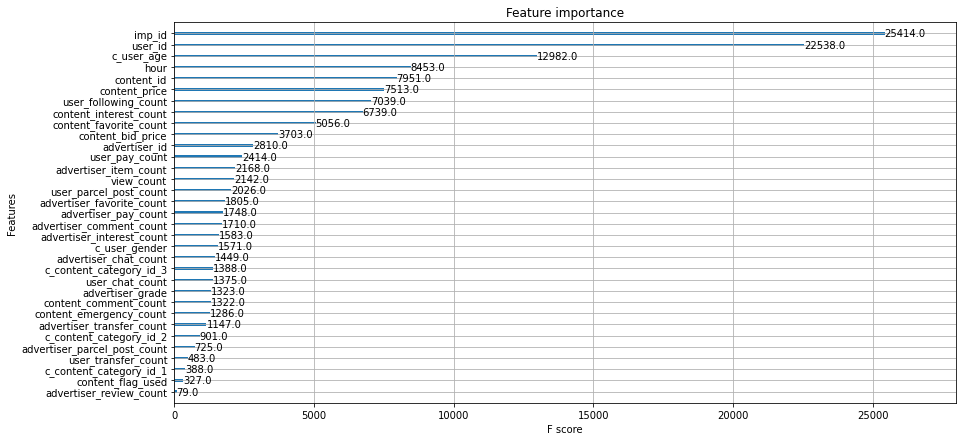

In [24]:
# XGBoost
xgbm.fit(X_train, y_train)


prior = log_loss(y_train, [avg_ctr]*len(y_train))

# pred & loss
pred_proba = xgbm.predict_proba(X_test)
pred = xgbm.predict(X_test)
logloss = log_loss(y_test, pred_proba)
AUC = roc_auc_score(y_test, pred)

# relative information gain
rig = (prior - logloss) / prior


print(f'test AUC : {AUC}')
print(f'test log loss : {logloss}')
print(f'rig : {rig}')
print('\n')


# feature importance plot
print('XGBoost : feature importance')
fig, ax = plt.subplots(figsize = (14, 7))
xgb.plot_importance(xgbm, ax=ax)

AUC 기준 xgboost의 성능이 가장 좋았습니다.

In [ ]:
save_download(xgbm, 'xgbm_auc_0.5577')

In [ ]:
# CatBoost
cbm.fit(X_train, y_train, verbose = False)


prior = log_loss(y_train, [avg_ctr]*len(y_train))

# pred & loss
pred_proba = cbm.predict_proba(X_test)
pred = cbm.predict(X_test)
logloss = log_loss(y_test, pred_proba)
AUC = roc_auc_score(y_test, pred)

# relative information gain
rig = (prior - logloss) / prior


print(f'test AUC : {AUC}')
print(f'test log loss : {logloss}')
print(f'rig : {rig}')
print('\n')


# print('CatBoost : feature importance')

# feature importance plot
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
    
# plot_feature_importance(catboost.get_feature_importance(),X_test.columns,'CATBOOST')

feature importance를 찍는 함수가 있는데, catboost에서는 다른 모델과 다른 방식으로 feature importance를 확인해야했기 때문입니다.  

In [ ]:
save_download(cbm, 'cbm_0.0918')

logloss 기준으로 catboost가 0.0918로 가장 높은 성능을 냈습니다.

In [ ]:
# RandomForestClassifier
rfm.fit(X_train, y_train)


prior = log_loss(y_train, [avg_ctr]*len(y_train))

# pred & loss
pred_proba = rfm.predict_proba(X_test)
pred = rfm.predict(X_test)
logloss = log_loss(y_test, pred_proba)
AUC = roc_auc_score(y_test, pred)

# relative information gain
rig = (prior - logloss) / prior


print(f'test AUC : {AUC}')
print(f'test log loss : {logloss}')
print(f'rig : {rig}')
print('\n')
# print('RandomForestClassifier : feature importance')

# feature importance plot
# fig, ax = plt.subplots(figsize = (14, 7))
# lgb.plot_importance(lgbm, ax=ax)

In [ ]:
save_download(rfm, 'rfm_0.0942')

In [31]:
# 임의 유저로 테스트해보자.

# 모델에 사용한 dataset에서 유저 정보를 드랍한다.
seonwoo_dataset = dataset.drop(['c_user_gender', 'c_user_age',
       'user_following_count', 'user_pay_count', 'user_parcel_post_count',
       'user_transfer_count', 'user_chat_count'], axis = 1)

# 임의 유저의 정보를 추가한다.
seonwoo_dataset['c_user_gender'] = 1
seonwoo_dataset['c_user_age'] = 34
seonwoo_dataset['user_following_count'] = 0
seonwoo_dataset['user_pay_count'] = 0
seonwoo_dataset['user_parcel_post_count'] = 0
seonwoo_dataset['user_transfer_count'] = 0
seonwoo_dataset['user_chat_count'] = 0

seonwoo_dataset_label = seonwoo_dataset['label']
seonwoo_dataset.drop('label', axis = 1, inplace = True)
seonwoo_dataset

,user_id,imp_id,content_id,content_bid_price,advertiser_id,content_price,content_flag_used,c_content_category_id_1,c_content_category_id_2,c_content_category_id_3,...,hour,view_count,content_count,c_user_gender,c_user_age,user_following_count,user_pay_count,user_parcel_post_count,user_transfer_count,user_chat_count
0,9729642,74973,526,50,3947717,155000,1,9,64,131,...,17,33,2.900391,1,34,0,0,0,0,0
1,3785173,269311,1020,50,3160588,250000,0,2,28,60,...,20,2,-0.199951,1,34,0,0,0,0,0
2,12333079,618849,1066,50,1543832,78800,1,2,34,74,...,6,56,5.199219,1,34,0,0,0,0,0
3,9079063,455676,243,50,12851816,200000,0,9,66,133,...,12,3,-0.099976,1,34,0,0,0,0,0
4,74280651,431740,244,60,12851816,419000,0,9,66,133,...,5,6,0.199951,1,34,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
718986,7758479,52419,47,50,1266155,70000,1,6,52,104,...,13,7,0.300049,1,34,0,0,0,0,0
718987,13020787,214739,731,65,3846821,399000,0,9,60,120,...,11,1,-0.300049,1,34,0,0,0,0,0
718988,74591039,100381,1242,60,824842,1200000,0,7,53,106,...,21,8,0.399902,1,34,0,0,0,0,0
718989,4523798,94712,365,50,2347538,195000,0,9,66,133,...,20,1,-0.300049,1,34,0,0,0,0,0


실제 추천을 하기 위해 임의 유저의 데이터를 입력하는 부분입니다.  
학습에 사용된 데이터셋에서 유저 정보와 관련된 컬럼을 모두 드랍하고 대신 임의의 유저 정보를 입력해서 컬럼을 다시 채웁니다.  
나머지 컬럼의 값들은 모두 동일하기 때문에 unseen data(유저 정보)를 넣어주고 '얘는 클릭할 것 같아 안 할것 같아?' 라고 물어보는 것과 같습니다.  
현재 cell은 광수님이 요청하신 성별 나이만 존재하고 나머지는 0인 유저를 기준으로 예측을 하기 위해 유저 정보를 입력한 것입니다.

In [32]:
compression_opts = dict(method='zip',
                        archive_name='가상인물데이터2.csv')  
seonwoo_dataset.to_csv('가상인물데이터2.zip', index=False,
          compression=compression_opts)

In [ ]:
seonwoo_dataset.isnull().sum()

혹시 모르니까 결측치가 있는지 확인해봤습니다.

In [33]:
# 임의 유저에 대해 prediction을 해보자.
probs = xgbm.predict_proba(seonwoo_dataset)

# 계산된 확률을 dataframe에 추가하자.
seonwoo_dataset['probs'] = probs[:, 1]

seonwoo_dataset

,user_id,imp_id,content_id,content_bid_price,advertiser_id,content_price,content_flag_used,c_content_category_id_1,c_content_category_id_2,c_content_category_id_3,...,view_count,content_count,c_user_gender,c_user_age,user_following_count,user_pay_count,user_parcel_post_count,user_transfer_count,user_chat_count,probs
0,9729642,74973,526,50,3947717,155000,1,9,64,131,...,33,2.900391,1,34,0,0,0,0,0,0.001988
1,3785173,269311,1020,50,3160588,250000,0,2,28,60,...,2,-0.199951,1,34,0,0,0,0,0,0.011746
2,12333079,618849,1066,50,1543832,78800,1,2,34,74,...,56,5.199219,1,34,0,0,0,0,0,0.001147
3,9079063,455676,243,50,12851816,200000,0,9,66,133,...,3,-0.099976,1,34,0,0,0,0,0,0.001486
4,74280651,431740,244,60,12851816,419000,0,9,66,133,...,6,0.199951,1,34,0,0,0,0,0,0.015596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
718986,7758479,52419,47,50,1266155,70000,1,6,52,104,...,7,0.300049,1,34,0,0,0,0,0,0.002145
718987,13020787,214739,731,65,3846821,399000,0,9,60,120,...,1,-0.300049,1,34,0,0,0,0,0,0.020006
718988,74591039,100381,1242,60,824842,1200000,0,7,53,106,...,8,0.399902,1,34,0,0,0,0,0,0.049823
718989,4523798,94712,365,50,2347538,195000,0,9,66,133,...,1,-0.300049,1,34,0,0,0,0,0,0.008111


AUC상 가장 성능이 좋았던 학습된 xgboost 모델을 이용해서 위에서 만든 임의 유저 데이터셋을 예측합니다.  
예측된 값(확률 값)을 컬럼에 추가합니다.  
확률이 높은 순으로 top-k개를 잘라내야 하기 때문입니다.

In [34]:
compression_opts = dict(method='zip',
                        archive_name='가상인물데이터2 예측 결과.csv')  
seonwoo_dataset.to_csv('가상인물데이터2 예측 결과.zip', index=False,
          compression=compression_opts)

In [ ]:
seonwoo_loss = log_loss(seonwoo_dataset_label, probs)
seonwoo_loss

임의 유저에 대해 진행한 prediction의 logloss도 한번 찍어봅니다. (큰 의미는 없습니다.)

In [35]:
# 임의 유저가 보게 될 확률이 높은 광고주 top-3에 대해.araboja

recommended = seonwoo_dataset.sort_values(by = ['probs'], ascending = False).drop_duplicates(['advertiser_id'], keep = 'first').head(3)
recommended

,user_id,imp_id,content_id,content_bid_price,advertiser_id,content_price,content_flag_used,c_content_category_id_1,c_content_category_id_2,c_content_category_id_3,...,view_count,content_count,c_user_gender,c_user_age,user_following_count,user_pay_count,user_parcel_post_count,user_transfer_count,user_chat_count,probs
576097,74668654,250229,294,55,74689400,1000000,1,2,28,61,...,2,-0.199951,1,34,0,0,0,0,0,0.844083
411524,74530573,220049,375,55,2347538,200000,0,9,66,133,...,1,-0.300049,1,34,0,0,0,0,0,0.795294
117042,13070227,328229,142,50,4776936,250000,1,16,89,185,...,1,-0.300049,1,34,0,0,0,0,0,0.792723


우리 데이터셋의 특성상 top-n개를 뽑으면 같은 광고주가 중복해서 추천될 가능성이 높습니다.  
그렇기 때문에 drop_duplicates로 advertiser_id 중복을 제거하고 내림차순 top-3를 뽑습니다.

In [36]:
compression_opts = dict(method='zip',
                        archive_name='가상인물데이터2 top-3 노편집.csv')  
recommended.to_csv('가상인물데이터2 top-3 노편집.zip', index=False,
          compression=compression_opts)

In [37]:
rec_adv = pd.DataFrame(recommended['advertiser_id'])
rec_adv

,advertiser_id
576097,74689400
411524,2347538
117042,4776936


top-3까지 잘린 데이터프레임에서 advertiser_id만 뽑아내면 임의의 유저가 볼 확률이 높은 광고주 top-3 명단이 만들어집니다.

In [38]:
# rec_adv.to_csv(index = False)

compression_opts = dict(method='zip',
                        archive_name='out2.csv')  
rec_adv.to_csv('xgb_output2.zip', index=False,
          compression=compression_opts)

In [ ]:
# plot

auc_df = pd.DataFrame({"RandomForest": [0.5061],
                       "LightGBM" : [0.5420],
                       'XGBoost' : [0.5577],
                       'CatBoost' : [0.5167]})

auc_df.rename(index = {0:'AUC'}, inplace = True)
auc_df
# sns.lineplot(data = auc_df)

각 모델의 AUC score를 기준으로 plot을 만들기 위해 데이터프레임을 만듭니다.  

In [ ]:
# plot
sns.set_style('whitegrid')
sns.set(rc = {'figure.figsize' : (15, 8)},
        font_scale = 2)
sns.lineplot(data = auc_df.T.reset_index().rename(columns = {'index' : 'model'}), 
             x = 'model', 
             y = 'AUC',
             color = 'r',
             linewidth = 3.5)
plt.title('AUC Score by Gradient Boosting Model')
plt.grid(True)

plt.savefig('auc_plot.png')



위에서 만든 데이터프레임을 이용해서 plot을 만들어봅니다.  
지금은 cell 출력 창이 지워졌지만 알집으로 발송한 plot 이미지 파일이 이 cell의 출력값에 해당합니다.